In [1]:
import numpy as np
import math


def parse_file(filename):
    X = []
    Y = []
    
    file = open(filename, mode = 'r', encoding = 'utf-8-sig')
    lines = file.readlines()
    file.close()
    for line in lines:
        line = line.split(' ')
        X.append([float(line[0]), float(line[1])])
        Y.append(float(line[2].strip()))
        
    return (X, Y)

def calc_entropy(Y):
    probability_true = sum(Y) / len(Y)
    if (probability_true == 0 or probability_true == 1):
        return 0
    else:
        return -(probability_true * math.log2(probability_true) 
             + (1 - probability_true) * (math.log2(1 - probability_true)))
    
def calc_info_gain(X, Y, feature_index, val):
    entropy_Y = calc_entropy(Y)
    
    split_result = split(X, Y, feature_index, val)
    Y_1 = split_result[1]
    Y_2 = split_result[3]
    if (len(Y_1) == 0 or len(Y_2) == 0):
        return 0
    
    entropy_Y1 = calc_entropy(Y_1)
    entropy_Y2 = calc_entropy(Y_2)
    
    return entropy_Y - ((len(Y_1)/len(Y)) * entropy_Y1 + (len(Y_2)/len(Y)) * entropy_Y2)

def calc_split_info(X, Y, feature_index, split_val):
    X_1, Y_1, X_2, Y_2 = split(X, Y, feature_index, split_val)
    
    P_Y1 = len(Y_1) / len(Y)
    P_Y2 = len(Y_2) / len(Y)
    return - (P_Y1 * math.log2(P_Y1) + P_Y2 * math.log2(P_Y2))
    
def split(X, Y, feature_index, split_val):
    X_1 = []
    Y_1 = []
    X_2 = []
    Y_2 = []
    
    for i in range(len(Y)):
        if (X[i][feature_index] >= split_val):
            X_1.append(X[i])
            Y_1.append(Y[i])
        else:
            X_2.append(X[i])
            Y_2.append(Y[i])
    
    return (X_1, Y_1, X_2, Y_2)

def calc_leaf_val(Y):
    if (len(Y) == 0):
        return 0
    
    percent_true = sum(Y) / len(Y)
    
    if percent_true >= 0.5:
        return 1
    else:
        return 0
    
def determine_possible_splits(X):
    possible_splits = []
    num_features = len(X[0])
    
    for i in range(num_features):
        feature_splits = []
        feature_splits_set = set()
        for j in range(len(X)):
            if X[j][i] not in feature_splits_set:
                feature_splits_set.add(X[j][i])
                feature_splits.append(X[j][i])
        feature_splits.sort()
        possible_splits.append(feature_splits)
    return possible_splits

def determine_best_split(X, Y):
    possible_splits = determine_possible_splits(X)
    
    feature_index = None
    split_val = None 
    max_gain_ratio = 0
    
    for i in range(len(possible_splits)):
        for j in range(len(possible_splits[i])):
            X_1, Y_1, X_2, Y_2 = split(X, Y, i, possible_splits[i][j])
            if (len(Y_1) > 0 and len(Y_2) > 0):
                info_gain = calc_info_gain(X, Y, i, possible_splits[i][j])
                split_info = calc_split_info(X, Y, i, possible_splits[i][j])
                gain_ratio = info_gain / split_info
                if (gain_ratio > max_gain_ratio):
                    max_gain_ratio = gain_ratio
                    feature_index = i
                    split_val = possible_splits[i][j]
    
    return (feature_index, split_val)

class Node:
    pass

class Leaf(Node):
    def __init__(self, parent):
        self.parent = parent
        self.label = None
        
class InternalNode(Node):
    def __init__(self, parent):
        self.parent = parent
        self.children = []
        self.feature_index = None
        self.split_val = None
        
class RootNode(Node):
    def __init__(self):
        self.children = []
        self.feature_index = None
        self.split_val = None
        
class DecisionTree:
    def __init__(self):
        self.root = RootNode()
        
    def calc_boundary_points(self, currentNode):
        if (currentNode == None):
            currentNode = self.root
            self.boundary_points = [[], []]
            split_val = self.root.split_val
            feature_index = self.root.feature_index
            if (feature_index == 0):
                self.boundary_points[0].append(split_val)
                self.boundary_points[1].append(0)
            else:
                self.boundary_points[0].append(0)
                self.boundary_points[1].append(split_val)
        else:
            feature_index = currentNode.feature_index
            split_val = currentNode.split_val
        
        children = currentNode.children
        left_child = children[0]
        right_child = children[1]
        last_point_x1 = self.boundary_points[0][-1]
        last_point_x2 = self.boundary_points[1][-1]
        
        if (isinstance(left_child, Leaf) or isinstance(right_child, Leaf)):
            if feature_index == 0:
                self.boundary_points[0].append(split_val)
                self.boundary_points[1].append(1)
            else:
                self.boundary_points[0].append(1)
                self.boundary_points[1].append(split_val)
        if (not isinstance(left_child, Leaf)):
            if (left_child.feature_index == 0):
                self.boundary_points[0].append(left_child.split_val)
                self.boundary_points[1].append(last_point_x2)
            else:
                self.boundary_points[0].append(last_point_x1)
                self.boundary_points[1].append(left_child.split_val)
            self.calc_boundary_points(left_child)
        if (not isinstance(right_child, Leaf)):
            if (right_child.feature_index == 0):
                self.boundary_points[0].append(right_child.split_val)
                self.boundary_points[1].append(last_point_x2)
            else:
                self.boundary_points[0].append(last_point_x1)
                self.boundary_points[1].append(right_child.split_val)
            self.calc_boundary_points(right_child)
        
        if (isinstance(currentNode, RootNode)):
            return self.boundary_points
        
    def calc_node_count(self, currentNode):
        if (currentNode == None):
            self.node_count = 1
            currentNode = self.root
        
        self.node_count += 2
        right_child = currentNode.children[0]
        left_child = currentNode.children[1]
        
        if (not isinstance(right_child, Leaf)):
            self.calc_node_count(right_child)
        if (not isinstance(left_child, Leaf)):
            self.calc_node_count(left_child)
            
        if (currentNode == self.root):
            return self.node_count
    
    def calc_error(self, X_test, Y_test):
        error_count = 0
        total_count = 0
        
        for i in range(len(X_test)):
            label = self.predict_label(X_test[i], None)
            total_count += 1
            if (label != Y_test[i]):
                error_count += 1
        
        return (error_count / total_count)
    
    def predict_label(self, x_point_data, currentNode):
        if (currentNode == None):
            currentNode = self.root
            
        feature_index = currentNode.feature_index
        if (feature_index == 0):
            go_left = (x_point_data[0] >= currentNode.split_val)
        else:
            go_left = (x_point_data[1] >= currentNode.split_val)
        
        if (go_left == True):
            if (isinstance(currentNode.children[0], Leaf)):
                return currentNode.children[0].label
            else:
                return self.predict_label(x_point_data, currentNode.children[0])
        else:
            if (isinstance(currentNode.children[1], Leaf)):
                return currentNode.children[1].label
            else:
                return self.predict_label(x_point_data, currentNode.children[1])
        
def build_decision_tree(X, Y, parentNode, printOutput, level):
    if (parentNode == None):
        tree = DecisionTree()
        currentNode = tree.root
        level = 0
    else:
        level += 1
    
    create_leaf = False
    
    if (len(Y) == 0):
        create_leaf = True
    else:
        feature_index, split_val = determine_best_split(X, Y)
        if (feature_index == None):
            create_leaf = True
        else:
            info_gain = calc_info_gain(X, Y, feature_index, split_val)
            split_info = calc_split_info(X, Y, feature_index, split_val)
            gain_ratio = info_gain / split_info
            if (gain_ratio <= 0):
                create_leaf = True
        
    if (create_leaf):
        currentNode = Leaf(parentNode)
        currentNode.label = calc_leaf_val(Y)
        if (printOutput == True):
            print((' ' * level) + "Leaf: " + "Label=" + str(currentNode.label))
        if (parentNode != None):
            parentNode.children.append(currentNode)
    else:
        X_1, Y_1, X_2, Y_2 = split(X, Y, feature_index, split_val)
        if (parentNode != None):
            currentNode = InternalNode(parentNode)
            parentNode.children.append(currentNode)
        if (printOutput == True):
            print((' ' * level) + "Internal Node: " + "SplitVal=" + str(split_val) + ", FeatureIndex=" + str(feature_index))
        currentNode.feature_index = feature_index
        currentNode.split_val = split_val
        build_decision_tree(X_1, Y_1, currentNode, printOutput, level)
        build_decision_tree(X_2, Y_2, currentNode, printOutput, level)
    
    if (parentNode == None):
        return tree

In [2]:
#Question 3:
X, Y = parse_file("Druns.txt")
possible_splits = determine_possible_splits(X)

for i in range(len(possible_splits)):
    for j in range(len(possible_splits[i])):
        X_1, Y_1, X_2, Y_2 = split(X, Y, i, possible_splits[i][j])
        print("Split Feature Index: " + str(i))
        print("Split Feature Value: " + str(possible_splits[i][j]))
        if (len(Y_1) > 0 and len(Y_2) > 0):
            info_gain = calc_info_gain(X, Y, i, possible_splits[i][j])
            print("Information Gain: " + str(info_gain))
            split_info = calc_split_info(X, Y, i, possible_splits[i][j])
            print("Information Gain Ratio: " + str(info_gain / split_info))
        else:
            print("Information Gain: 0") #Already know the information gain will be zero if all split will not actually split the data
        print("------------------------------------------------------")

Split Feature Index: 0
Split Feature Value: 0.0
Information Gain: 0
------------------------------------------------------
Split Feature Index: 0
Split Feature Value: 0.1
Information Gain: 0.04417739186726133
Information Gain Ratio: 0.10051807676021828
------------------------------------------------------
Split Feature Index: 1
Split Feature Value: -2.0
Information Gain: 0
------------------------------------------------------
Split Feature Index: 1
Split Feature Value: -1.0
Information Gain: 0.04417739186726133
Information Gain Ratio: 0.10051807676021828
------------------------------------------------------
Split Feature Index: 1
Split Feature Value: 0.0
Information Gain: 0.03827452220629246
Information Gain Ratio: 0.055953759631263526
------------------------------------------------------
Split Feature Index: 1
Split Feature Value: 1.0
Information Gain: 0.004886164091842726
Information Gain Ratio: 0.00578004220515232
------------------------------------------------------
Split Feat

In [3]:
#Question 4:
X, Y = parse_file("D3Leaves.txt")
tree = build_decision_tree(X, Y, None, True, None)

Internal Node: SplitVal=10.0, FeatureIndex=0
 Leaf: Label=1
 Internal Node: SplitVal=3.0, FeatureIndex=1
  Leaf: Label=1
  Leaf: Label=0


In [4]:
#Question 5 (D1):
X, Y = parse_file("D1.txt")
tree = build_decision_tree(X, Y, None, True, None)

Internal Node: SplitVal=0.201829, FeatureIndex=1
 Leaf: Label=1
 Leaf: Label=0


In [5]:
#Question 5 (D2):
X, Y = parse_file("D2.txt")
tree = build_decision_tree(X, Y, None, True, None)

Internal Node: SplitVal=0.533076, FeatureIndex=0
 Internal Node: SplitVal=0.228007, FeatureIndex=1
  Internal Node: SplitVal=0.424906, FeatureIndex=1
   Leaf: Label=1
   Internal Node: SplitVal=0.708127, FeatureIndex=0
    Leaf: Label=1
    Internal Node: SplitVal=0.32625, FeatureIndex=1
     Internal Node: SplitVal=0.595471, FeatureIndex=0
      Internal Node: SplitVal=0.646007, FeatureIndex=0
       Leaf: Label=1
       Internal Node: SplitVal=0.403494, FeatureIndex=1
        Leaf: Label=1
        Leaf: Label=0
      Leaf: Label=0
     Leaf: Label=0
  Internal Node: SplitVal=0.887224, FeatureIndex=0
   Internal Node: SplitVal=0.037708, FeatureIndex=1
    Internal Node: SplitVal=0.082895, FeatureIndex=1
     Leaf: Label=1
     Internal Node: SplitVal=0.960783, FeatureIndex=0
      Leaf: Label=1
      Leaf: Label=0
    Leaf: Label=0
   Internal Node: SplitVal=0.850316, FeatureIndex=0
    Internal Node: SplitVal=0.169053, FeatureIndex=1
     Leaf: Label=1
     Leaf: Label=0
    Leaf: La

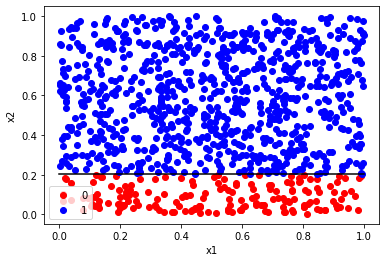

In [6]:
#Question 6 - D1 Plot

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig, ax = plt.subplots()
X, Y = parse_file("D1.txt")
tree = build_decision_tree(X, Y, None, False, None)

boundary_points = tree.calc_boundary_points(None)

data_label_zero_x1 = []
data_label_zero_x2 = []
data_label_one_x1 = []
data_label_one_x2 = []

for i in range(len(X)):
    if (Y[i] == 0):
        data_label_zero_x1.append(X[i][0])
        data_label_zero_x2.append(X[i][1])
    else:
        data_label_one_x1.append(X[i][0])
        data_label_one_x2.append(X[i][1])
   
line = mlines.Line2D(boundary_points[0], boundary_points[1], c='black')
ax.add_line(line)
ax.scatter(data_label_zero_x1, data_label_zero_x2, label='0', c='red')
ax.scatter(data_label_one_x1, data_label_one_x2, label='1', c='blue')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend()

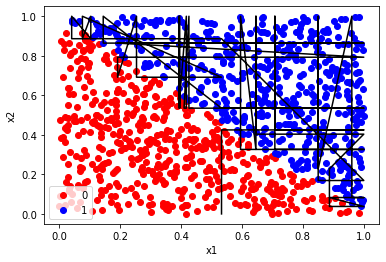

In [7]:
#Question 6 - D2 Plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
X, Y = parse_file("D2.txt")
tree = build_decision_tree(X, Y, None, False, None)

boundary_points = tree.calc_boundary_points(None)

data_label_zero_x1 = []
data_label_zero_x2 = []
data_label_one_x1 = []
data_label_one_x2 = []

for i in range(len(X)):
    if (Y[i] == 0):
        data_label_zero_x1.append(X[i][0])
        data_label_zero_x2.append(X[i][1])
    else:
        data_label_one_x1.append(X[i][0])
        data_label_one_x2.append(X[i][1])

line = mlines.Line2D(boundary_points[0], boundary_points[1], c='black')
ax.add_line(line)
ax.scatter(data_label_zero_x1, data_label_zero_x2, label='0', c='red')
ax.scatter(data_label_one_x1, data_label_one_x2, label='1', c='blue')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend()

In [8]:
#Question 7
import random

X_sorted, Y_sorted = parse_file("Dbig.txt")
rand_list = [i for i in range(len(X_sorted))]
random.shuffle(rand_list)
X = []
Y = []

for i in range(len(X_sorted)):
    X.append(X_sorted[rand_list[i]])
    Y.append(Y_sorted[rand_list[i]])

X_Test = X[8192:]
Y_Test = Y[8192:]
X_8192 = X[0:8192]
Y_8192 = Y[0:8192]
X_2048 = X_8192[0:2048]
Y_2048 = Y_8192[0:2048]
X_512 = X_2048[0:512]
Y_512 = Y_2048[0:512]
X_128 = X_512[0:128]
Y_128 = Y_512[0:128]
X_32 = X_128[0:32]
Y_32 = Y_128[0:32]

tree_8192 = build_decision_tree(X_8192, Y_8192, None, False, None)
tree_2048 = build_decision_tree(X_2048, Y_2048, None, False, None)
tree_512 = build_decision_tree(X_512, Y_512, None, False, None)
tree_128 = build_decision_tree(X_128, Y_128, None, False, None)
tree_32 = build_decision_tree(X_32, Y_32, None, False, None)

[275, 139, 63, 23, 7]


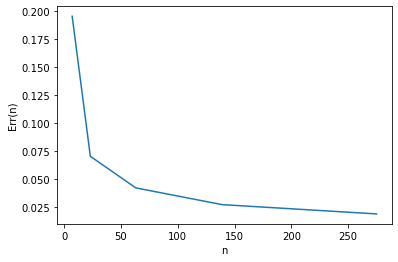

In [9]:
#Question 7 (continued)
import matplotlib.pyplot as plt

node_count_list = []
node_count_list.append(tree_8192.calc_node_count(None))
node_count_list.append(tree_2048.calc_node_count(None))
node_count_list.append(tree_512.calc_node_count(None))
node_count_list.append(tree_128.calc_node_count(None))
node_count_list.append(tree_32.calc_node_count(None))
print(node_count_list)

error_list = []
error_list.append(tree_8192.calc_error(X_Test, Y_Test))
error_list.append(tree_2048.calc_error(X_Test, Y_Test))
error_list.append(tree_512.calc_error(X_Test, Y_Test))
error_list.append(tree_128.calc_error(X_Test, Y_Test))
error_list.append(tree_32.calc_error(X_Test, Y_Test))

plt.close()
pltErr = plt.plot(node_count_list, error_list)
plt.xlabel("n")
plt.ylabel("Err(n)")
plt.show()

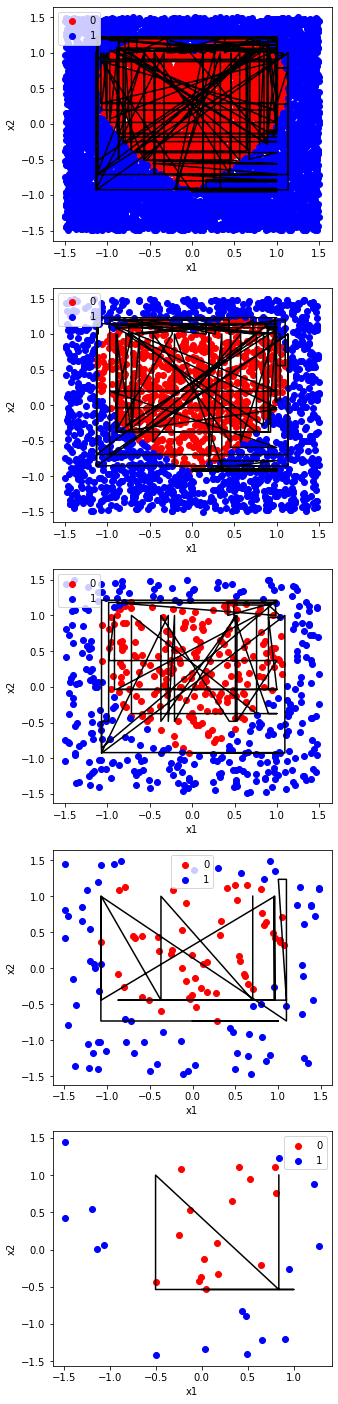

In [11]:
#Question 7 (continued)

tree_list = [tree_8192, tree_2048, tree_512, tree_128, tree_32]
X_list = [X_8192, X_2048, X_512, X_128, X_32]
Y_list = [Y_8192, Y_2048, Y_512, Y_128, Y_32]

fig, axs = plt.subplots(len(tree_list), 1, figsize=(5,25))

for i in range(len(tree_list)):
    tree = tree_list[i]
    X = X_list[i]
    Y = Y_list[i]

    boundary_points = tree.calc_boundary_points(None)

    data_label_zero_x1 = []
    data_label_zero_x2 = []
    data_label_one_x1 = []
    data_label_one_x2 = []

    for k in range(len(X)):
        if (Y[k] == 0):
            data_label_zero_x1.append(X[k][0])
            data_label_zero_x2.append(X[k][1])
        else:
            data_label_one_x1.append(X[k][0])
            data_label_one_x2.append(X[k][1])

    line = mlines.Line2D(boundary_points[0], boundary_points[1], c='black')
    axs[i].add_line(line)
    axs[i].scatter(data_label_zero_x1, data_label_zero_x2, label='0', c='red')
    axs[i].scatter(data_label_one_x1, data_label_one_x2, label='1', c='blue')
    axs[i].set_xlabel('x1')
    axs[i].set_ylabel('x2')
    axs[i].legend()